## Описание проекта:

**Описание данных:**   
**Признаки:**
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя   

**Целевой признак:**
* Price — цена (евро)

Заказчику важны:   
* качество предсказания;
* скорость предсказания;
* время обучения.

## Импорт библиотек:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import time

import catboost as ctb
print('catboost version:', ctb.__version__)
import xgboost as xgb
print('xgboost version:', xgb.__version__)
import lightgbm as lgb
print('lightgbm version:', lgb.__version__)

catboost version: 0.26.1
xgboost version: 1.5.2
lightgbm version: 3.2.1


In [2]:
import warnings
warnings.filterwarnings(action='ignore')

## Подготовка данных

### Предобработка данных

Изучим данные:

In [3]:
data = pd.read_csv('autos.csv')
df = data.copy()

In [4]:
data['LastSeen'].max()

'2016-04-07 14:58:51'

In [5]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
df = df.drop(['DateCrawled', 'DateCreated', 'PostalCode', 'LastSeen'], axis=1) #дропаем лишние признаки

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354369 non-null  int64 
 1   VehicleType        316879 non-null  object
 2   RegistrationYear   354369 non-null  int64 
 3   Gearbox            334536 non-null  object
 4   Power              354369 non-null  int64 
 5   Model              334664 non-null  object
 6   Kilometer          354369 non-null  int64 
 7   RegistrationMonth  354369 non-null  int64 
 8   FuelType           321474 non-null  object
 9   Brand              354369 non-null  object
 10  NotRepaired        283215 non-null  object
 11  NumberOfPictures   354369 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 32.4+ MB


In [8]:
(df.isna().sum() / df.shape[0] * 100).round(2) #Процент пропущенных значений по признакам до второго знака

Price                 0.00
VehicleType          10.58
RegistrationYear      0.00
Gearbox               5.60
Power                 0.00
Model                 5.56
Kilometer             0.00
RegistrationMonth     0.00
FuelType              9.28
Brand                 0.00
NotRepaired          20.08
NumberOfPictures      0.00
dtype: float64

In [9]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0


In [10]:
df.describe(include='object')

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
count,316879,334536,334664,321474,354369,283215
unique,8,2,250,7,40,2
top,sedan,manual,golf,petrol,volkswagen,no
freq,91457,268251,29232,216352,77013,247161


In [11]:
df.duplicated().sum() #количество дубликатов

27543

In [12]:
df = df.drop_duplicates().reset_index(drop=True) #удаляем повторы
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,NumberOfPictures
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,0
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,0
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,0
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,0
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,0
...,...,...,...,...,...,...,...,...,...,...,...,...
326821,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,0
326822,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,0
326823,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,0
326824,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,0


Датасет содержит в себе отсутствующие значения в категориальных признаках - таких, как тип машины, коробки передач или данные о ремонте. Природа этих пропусков неизвестна - например, в случае типа машины это могут быть как отсутствующие значения (например, продавец не указывал в анкете), так и не указанные в анкете типы кузовов. Так как пропуски находятся у *категориальных номинальных* признаков, мы планируем применять one-hot-encoding для каждого из них - в таком случае, пропуски заполнять не требуется.   
Признак `NumberOfPictires` пустой, его следует удалить.   
Ряд признаков, такие как целевой (Price), год регистрации содержат в себе нулевые и/или выпадающие значения (такие, как 9999 год регистрации). Признаки с такими значениями необходимо рассмотреть отдельно.   
Кроме того, приведем названия признаков в надлежащий вид

In [13]:
df = df.drop('NumberOfPictures', axis=1)
df.columns = df.columns.str.lower()
df.columns = ['price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 'model',
       'kilometer', 'registration_month', 'fuel', 'brand', 'not_repaired']

Данные готовы к исследовательскому анализу

### Исследовательский анализ данных

Рассмотрим распределения признаков

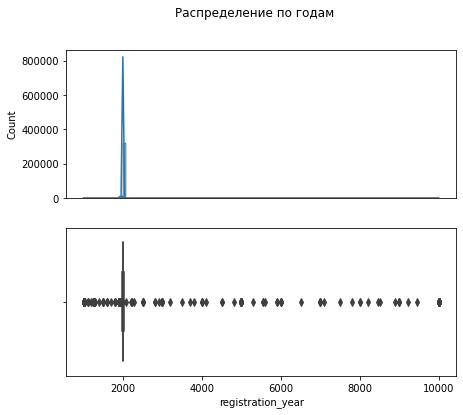

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(7,6))
plt.suptitle('Распределение по годам')
axes[0].xaxis.set_visible(False)
sns.histplot(data=df, ax=axes[0], x='registration_year',
             kde=True, bins=100)
sns.boxplot(data=df, ax=axes[1], x='registration_year')
pass

Удалим выбросы (все машины, с годом регистрации выше 2016 и ниже 1995 года)

In [15]:
df = df[(df['registration_year'] <= 2016) & (df['registration_year'] >= 1995)]

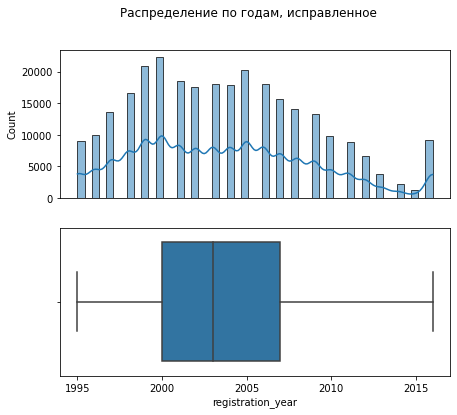

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(7,6))
plt.suptitle('Распределение по годам, исправленное')
axes[0].xaxis.set_visible(False)
sns.histplot(data=df, ax=axes[0], x='registration_year',
             bins=50, kde=True)
sns.boxplot(data=df, ax=axes[1], x='registration_year')
pass

Мы можем наблюдать распределение, похожее на бимодальное, с дополнительным пиком в районе 2016 года. Теперь данные по годам очщены от выбросов.   

Оценим распределение целевого признака

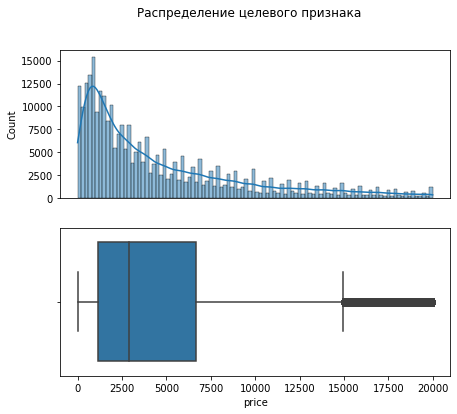

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(7,6))
plt.suptitle('Распределение целевого признака')
axes[0].xaxis.set_visible(False)
sns.histplot(data=df, ax=axes[0], x='price',
             kde=True, bins=100)
sns.boxplot(data=df, ax=axes[1], x='price')
pass

Распределение имеет длинный хвост вправо, большое количество околонулевых значений. Было принято решение не удалять хвостовые значения цены, чтобы модель могла обучиться узнавать дорогие марки и модели авто.   
Удалим все значения из датасета, цена которых ниже первого квантиля



In [18]:
quantile_1 = df['price'].quantile(0.25)
df = df[df['price'] >= quantile_1]
df['price'].describe()

count    217092.000000
mean       5899.424907
std        4562.612255
min        1150.000000
25%        2300.000000
50%        4300.000000
75%        8200.000000
max       20000.000000
Name: price, dtype: float64

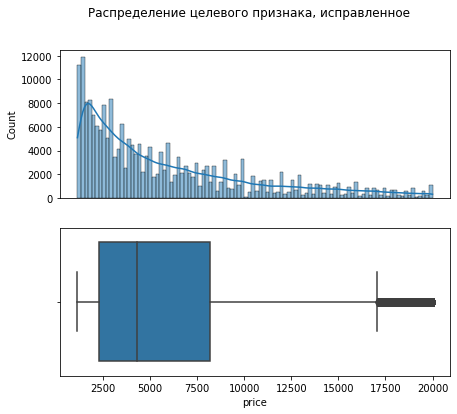

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(7,6))
plt.suptitle('Распределение целевого признака, исправленное')
axes[0].xaxis.set_visible(False)
sns.histplot(data=df, ax=axes[0], x='price',
             kde=True, bins=100)
sns.boxplot(data=df, ax=axes[1], x='price')
pass

Рассмотрим распределение по мощности двигателя, так как там также были артефактные значения

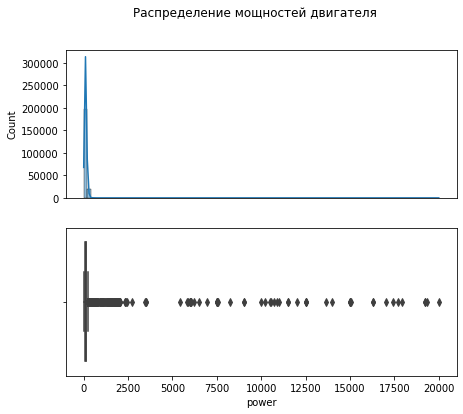

In [20]:
fig, axes = plt.subplots(2, 1, figsize=(7,6))
plt.suptitle('Распределение мощностей двигателя')
axes[0].xaxis.set_visible(False)
sns.histplot(data=df, ax=axes[0], x='power',
             kde=True, bins=100)
sns.boxplot(data=df, ax=axes[1], x='power')
pass

Мы избавимся от объектов, у которых мощность двигателя превышает 2000 л.с., так как это максимум для машин, находящихся в открытой продаже (Бугатти Вейрон).   
Кроме того, удалим машины с мощностью двигателя меньше 50 л.с.

In [21]:
df = df[(df['power'] <= 2000) & (df['power'] >= 50)]

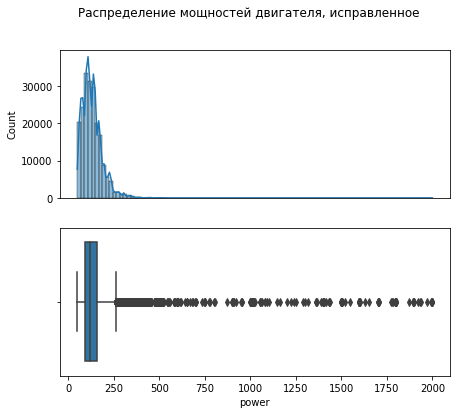

In [22]:
fig, axes = plt.subplots(2, 1, figsize=(7,6))
plt.suptitle('Распределение мощностей двигателя, исправленное')
axes[0].xaxis.set_visible(False)
sns.histplot(data=df, ax=axes[0], x='power',
             kde=True, bins=100)
sns.boxplot(data=df, ax=axes[1], x='power')
pass

После обработки распределение все равно имеет ярко выраженный хвост вправо, который было решено оставить - так модель сможет обучиться узнавать мощные автомобили

In [23]:
print(sorted(df['registration_month'].unique()))
print(df['registration_month'].unique().shape)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
(13,)


Признак `registration_month` содержит в себе на один месяц больше, чем необходимо. Посмотрим на количество упоминаний каждого месяца

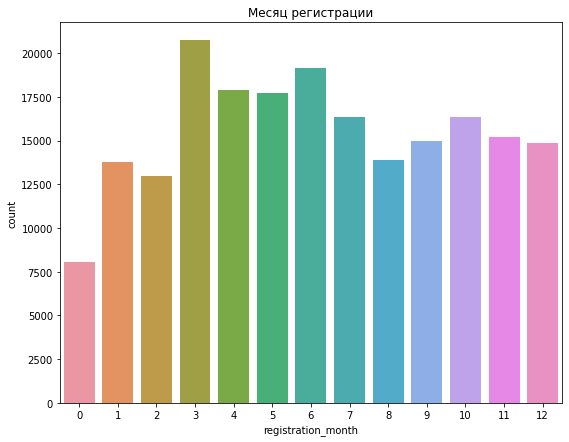

In [24]:
plt.figure(figsize=(9,7))
plt.title('Месяц регистрации')

sns.countplot(data=df, x='registration_month')

pass

Предположим, что значения `0` и `1` обозначают один и тот же месяц - январь. Заменим значения

In [25]:
df['registration_month'] = df['registration_month'].replace(0, 1)
df['registration_month'].unique()

array([ 5,  8,  6,  7, 12,  2,  3,  1,  4,  9, 11, 10], dtype=int64)

### Результаты

Был проведен исследовательский и статистический анализ данных:
* Анализ выявил большое количество пропущенных значений, происхождение - неизвестно, принято решение оставить
* С помощью визуального анализа и с использованием сторонних ресурсов были удалены выбросы в ряде признаков
* Данные подготовлены к обучению моделей

## Обучение моделей

Для начала мы попробуем обучить на данных простые модели регрессии с использованием библиотеки scikit-learn. Разделим данные на обучающую и тестовую выборки. Категориальные переменные закодируем с использованием one-hot-encoding, некоторые числовые нормализуем.   
После этого проверим несколько простых моделей регрессии на данных. Метрикой качества выберем RMSE

In [26]:
X = df.drop('price', axis=1)
y = df['price']

cat_features = X[['vehicle_type', 'gearbox', 'model', 'fuel', 'brand', 'not_repaired']].columns #OHE
X = pd.get_dummies(data=X, columns=cat_features, drop_first=True)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=1) 
for i in [X_train, X_test, y_train, y_test]:
  print(i.shape, '\n')

(141394, 302) 

(60598, 302) 

(141394,) 

(60598,) 



In [28]:
num_features = df[['power', 'kilometer']].columns

preprocessing = ColumnTransformer(
    transformers=[('numerical', MinMaxScaler(), num_features)],
                  remainder='passthrough'
)

In [29]:
regressors = [
              LinearRegression(n_jobs=-1),
              Ridge(),
              LinearSVR(random_state=47),
              DecisionTreeRegressor(random_state=47, max_depth=10),
              RandomForestRegressor(random_state=47, n_estimators=50, max_depth=10, n_jobs=-1)
]

results = {}

for regression in regressors:
  pipe = Pipeline(steps=[
                         ('preprocessing', preprocessing),
                         ('regressor', regression)
  ])
  start_time = time.time()
  pipe.fit(X_train, y_train)
  fit_time = time.time() - start_time

  preds_train = pipe.predict(X_train)
  start_time = time.time()
  preds_test = pipe.predict(X_test)
  predict_time = time.time() - start_time

  score_train = np.sqrt(mean_squared_error(y_train, preds_train))
  score_test = np.sqrt(mean_squared_error(y_test, preds_test))

  results.update({regression.__class__.__name__: [round(score_train, 2), round(score_test, 2), round(fit_time, 4), round(predict_time, 2)]})

results_final = pd.DataFrame(data=results,
                          index=['RMSE train', 'RMSE test', 'Learning Time', 'Prediction Time'])

In [30]:
results_final

,LinearRegression,Ridge,LinearSVR,DecisionTreeRegressor,RandomForestRegressor
RMSE train,2385.4200,2385.6000,5316.0600,1881.9500,1779.1000
RMSE test,2385.9400,2386.1700,5323.3800,1993.3600,1874.0200
Learning Time,2.8526,0.6453,26.1473,2.6878,27.3641
Prediction Time,0.1300,0.1300,0.1300,0.1500,0.2400


Линейная регрессия без регуляризации плохо показывает себя на этом датасете. Линейный СВМ также не справился. Лучше всего себя показали алгоритмы решающего дерева и случайного леса (с переобучением).   
Таким образом, для выполнения поставленной задачи необходимо попробовать ансамблевые методы

### XGBoost

In [31]:
xgb_reg = xgb.XGBRegressor(n_estimators=1000, max_depth=5, eta=0.3, random_state=47)

pipe = Pipeline(steps=[
                         ('preprocessing', preprocessing),
                         ('regressor', xgb_reg)
  ])
start_time = time.time()
pipe.fit(X_train, y_train)
fit_time = time.time() - start_time

preds_train = pipe.predict(X_train)
start_time = time.time()
preds_test = pipe.predict(X_test)
predict_time = time.time() - start_time

score_train = np.sqrt(mean_squared_error(y_train, preds_train))
score_test = np.sqrt(mean_squared_error(y_test, preds_test))

results.update({'XGBoostRegressor': [round(score_train, 2), round(score_test, 2), round(fit_time, 2), round(predict_time, 4)]})

results_final = pd.DataFrame(data=results,
                          index=['RMSE train', 'RMSE test', 'Learning Time', 'Prediction Time'])

In [32]:
results_final

,LinearRegression,Ridge,LinearSVR,DecisionTreeRegressor,RandomForestRegressor,XGBoostRegressor
RMSE train,2385.4200,2385.6000,5316.0600,1881.9500,1779.1000,1305.4800
RMSE test,2385.9400,2386.1700,5323.3800,1993.3600,1874.0200,1546.1200
Learning Time,2.8526,0.6453,26.1473,2.6878,27.3641,267.9300
Prediction Time,0.1300,0.1300,0.1300,0.1500,0.2400,0.4997


Экстремальный бустинг выдает меньшую ошибку, нежели остальные алгоритмы, хоть и переобучается (исправимо с более точной настройков параметров обучения и использованием валидации).   
Попробуем библиотеку CatBoost

### CatBoost

In [33]:
#Для обучения CatBoostRegressor нам не нужно кодирование
X = df.drop('price', axis=1)
y = df['price']

cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel', 'brand', 'not_repaired']
X[cat_features] = X[cat_features].astype(str)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=1)

In [34]:
cat_reg = ctb.CatBoostRegressor(iterations=1000, max_depth=5, learning_rate=0.3, random_state=47, cat_features=cat_features, verbose=0)

start_time = time.time()
cat_reg.fit(X_train, y_train)
fit_time = time.time() - start_time

preds_train = cat_reg.predict(X_train)
start_time = time.time()
preds_test = cat_reg.predict(X_test)
predict_time = time.time() - start_time

score_train = np.sqrt(mean_squared_error(y_train, preds_train))
score_test = np.sqrt(mean_squared_error(y_test, preds_test))

results.update({'CatBoostRegressor': [round(score_train, 2), round(score_test, 2), round(fit_time, 2), round(predict_time, 2)]})

results_final = pd.DataFrame(data=results,
                          index=['RMSE train', 'RMSE test', 'Learning Time', 'Prediction Time'])

In [35]:
results_final

,LinearRegression,Ridge,LinearSVR,DecisionTreeRegressor,RandomForestRegressor,XGBoostRegressor,CatBoostRegressor
RMSE train,2385.4200,2385.6000,5316.0600,1881.9500,1779.1000,1305.4800,1477.88
RMSE test,2385.9400,2386.1700,5323.3800,1993.3600,1874.0200,1546.1200,1558.92
Learning Time,2.8526,0.6453,26.1473,2.6878,27.3641,267.9300,76.98
Prediction Time,0.1300,0.1300,0.1300,0.1500,0.2400,0.4997,0.26


CatBoostRegressor обучается в разы быстрее XGBoostRegressor, и при этом гораздо меньше переобучается и не требует кодирования переменных. Результат также можно улучшить точной настройкой параметров.   
Проверим библиотеку LightGBM

### LightGBM

In [36]:
#LightGBM также принимает категориальные переменные

X[cat_features] = X[cat_features].astype('category')
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=1)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=1)

In [38]:
lgb_reg = lgb.LGBMRegressor()
start_time = time.time()
lgb_reg.fit(X_train, y_train)
fit_time = time.time() - start_time

preds_train = lgb_reg.predict(X_train)
start_time = time.time()
preds_test = lgb_reg.predict(X_test)
preds_time = time.time() - start_time

score_train = np.sqrt(mean_squared_error(y_train, preds_train))
score_test = np.sqrt(mean_squared_error(y_test, preds_test))

results.update({'LightGBMRegressor': [round(score_train, 2), round(score_test, 2), round(fit_time, 2), round(preds_time, 2)]})

results_final = pd.DataFrame(data=results,
                          index=['RMSE train', 'RMSE test', 'Learning Time', 'Prediction Time'])

In [39]:
results_final

,LinearRegression,Ridge,LinearSVR,DecisionTreeRegressor,RandomForestRegressor,XGBoostRegressor,CatBoostRegressor,LightGBMRegressor
RMSE train,2385.4200,2385.6000,5316.0600,1881.9500,1779.1000,1305.4800,1477.88,1519.99
RMSE test,2385.9400,2386.1700,5323.3800,1993.3600,1874.0200,1546.1200,1558.92,1577.18
Learning Time,2.8526,0.6453,26.1473,2.6878,27.3641,267.9300,76.98,1.09
Prediction Time,0.1300,0.1300,0.1300,0.1500,0.2400,0.4997,0.26,0.25


LightGBM показывает себя хуже остальных алгоритмов градиентных бустингов, но 
при этом обучается мгновенно и практически не переобучается.  

## Результаты и выводы

Был получен датасет с данными о продаже автомобилей. В датасете присутствовали отсутствующие значения (до 20% в некоторых признаках), кроме того, в ряде признаков были обнаружены аномальные значения. Перед обучением моделей датасет был обработан, в случае обучения простых моделей и алгоритма экстремального бустинга признаки были закодированы с применением метода One-Hot-Encoding. Алгоритм CatBoost обучался без применения кодирования, LightGBM обучался с применением OrdinaryEncoder.   
В результате самую низкую ошибку показала модель XGBoostRegressor, с небольшим отставанием расположилась модель CatBoostRegressor. Учитывая, что в требованиях к модели значилась не только метрика, но и скорость обучения, выбираем модель CatBoostRegressor, которая показала среднюю скорость обучения и достаточно низкую ошибку по сравнению с другими алгоритмами. 

Рассмотрим feature importance для выбранной модели

In [40]:
feat_imp = pd.Series(data=cat_reg.feature_importances_,
                        index=X.columns)

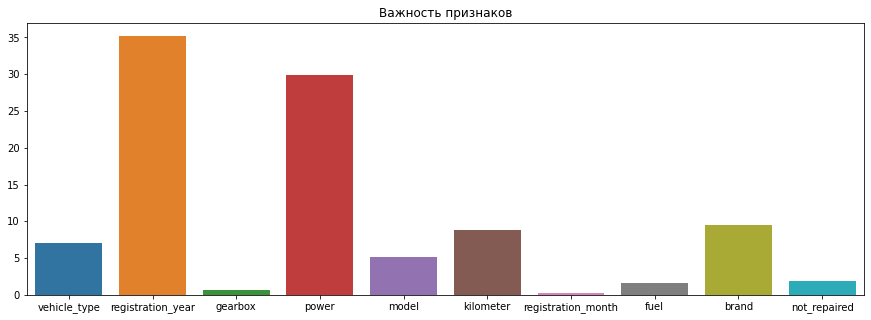

In [41]:
plt.figure(figsize=(15,5))
plt.title('Важность признаков')
sns.barplot(x=feat_imp.index, y=feat_imp.values)

pass

Для модели CatBoostRegressor самыми важными признаками оказались год регистрации автомобиля и мощность его двигателя. Так как мы убрали из выборки для обучения старые автомобили, можно предположить, что новейшие машины продаются дороже, нежели более старые.   
Ситуация с двигателем легко объяснима - более дорогие модели имеют больше лошадиных сил под капотом.   
На третьем месте с практически одинаковым скором расположились марка машины, ее тип и пробег.   
В то же время такие признаки, как тип коробки передач и месяц регистрации практически не влияют на предсказание модели - вероятно, стоит попробовать обучить модель без них и сравнить метрики.